In [1]:
import sys
import os
import pandas as pd
import numpy as np
import scanpy as sc
import torch
import json
import shutil
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from geneformer import Classifier
from datasets import Dataset, load_from_disk
from datasets import load_dataset

/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load tokens

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/hematokytos/reference/token_map.csv"
tokens = pd.read_csv(fpath)
tokens.head()


,gene_id,token_id,gene_name,gene_biotype,Chromosome,Start,End
0,<pad>,0,NaN,NaN,NaN,NaN,NaN
1,<mask>,1,NaN,NaN,NaN,NaN,NaN
2,ENSG00000000003,2,TSPAN6,protein_coding,X,100627107.0,100639991.0
3,ENSG00000000005,3,TNMD,protein_coding,X,100584935.0,100599885.0
4,ENSG00000000419,4,DPM1,protein_coding,20,50934866.0,50959140.0


# Load marker Genes

In [3]:
def load_pathway(fpath):
    """
    Loads an Enrichr-like database file into a boolean DataFrame.

    Args:
        fpath (str): Path to the Enrichr-like database file.

    Returns:
        pandas.DataFrame: A boolean DataFrame where:
            - Index: Genes
            - Columns: Pathways
            - Values: True if the gene is in the pathway, False otherwise.
    """

    result = []
    with open(fpath) as f:
        for line in f:
            split_line = [x for x in line.strip().split('\t') if x]  # Remove empty strings directly

            row = {'label': split_line[0]}
            for gene in split_line[1:]:
                row[gene] = 1

            result.append(row)

    df = pd.DataFrame(result)
    df = df.fillna(0.0).set_index('label').astype(bool).T  # Chained operations for clarity

    return df


fpath = "../resources/PanglaoDB_Augmented_2021.txt"
pang = load_pathway(fpath)
pang.head()

label,Acinar Cells,Adipocyte Progenitor Cells,Adipocytes,Adrenergic Neurons,Airway Epithelial Cells,Airway Goblet Cells,Airway Smooth Muscle Cells,Alpha Cells,Alveolar Macrophages,Anterior Pituitary Gland Cells,...,Transient Cells,Trichocytes,Trigeminal Neurons,Trophoblast Cells,Trophoblast Progenitor Cells,Trophoblast Stem Cells,Tuft Cells,Undefined Placental Cells,Urothelial Cells,Vascular Smooth Muscle Cells
GDF15,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
RARRES2,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
TM4SF4,True,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
CELA1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
GCG,True,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


# Extract the HSC tokens

In [4]:
hsc_genes = list(pang[pang['Hematopoietic Stem Cells']].index)
print(hsc_genes[:10])

hsc_tokens = tokens[tokens['gene_name'].isin(hsc_genes)]
print(f"{hsc_tokens.shape=}")
hsc_tokens.head()

['GJB1', 'ANPEP', 'LYZ', 'RNASE1', 'GATA3', 'STAB1', 'SERPING1', 'TNS1', 'TLR2', 'TLR4']
hsc_tokens.shape=(177, 7)


,gene_id,token_id,gene_name,gene_biotype,Chromosome,Start,End
113,ENSG00000005961,113,ITGA2B,protein_coding,17,44372179.0,44389649.0
168,ENSG00000007062,168,PROM1,protein_coding,4,15963075.0,16084378.0
220,ENSG00000008394,220,MGST1,protein_coding,12,16347141.0,16609259.0
263,ENSG00000010327,263,STAB1,protein_coding,3,52495337.0,52524495.0
309,ENSG00000011600,309,TYROBP,protein_coding,19,35904400.0,35908295.0


# Load Data

In [5]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/hematokytos/tokenized_data/merged_adata.dataset"
data = load_from_disk(fpath)
data = data.filter(lambda x: x['dataset_x'] in ['iHSC', 'sc_fib', 'weng_young2_HSC'])
df = data.to_pandas()
label_map = {
    'iHSC' : 'iHSC',
    'sc_fib' : 'scFib',
    'weng_young2_HSC' : 'Native HSC',
    
}

df['label'] = df['dataset_x'].map(label_map)
df.head()

,n_genes,dataset_x,n_genes_by_counts,total_counts,obs_index,cell_type,dataset_y,standard_cell_type,cell_id,input_ids,length,total_length,label
0,1950,weng_young2_HSC,1949,11532.148941,AAACAGCCAACCCTAA-3,HSC,weng_young2_HSC,HSC,AAACAGCCAACCCTAA-3_weng_young2_HSC,"[3671, 1756, 14476, 7289, 24562, 14132, 1298, ...",2048,1949,Native HSC
1,1451,weng_young2_HSC,1446,8973.424214,AAACAGCCATAGGCGA-3,HSC,weng_young2_HSC,HSC,AAACAGCCATAGGCGA-3_weng_young2_HSC,"[14476, 7947, 7289, 2072, 8325, 2080, 4655, 23...",2048,1446,Native HSC
2,3804,weng_young2_HSC,3795,19644.194682,AAACATGCAGCTAACC-3,MKP,weng_young2_HSC,MKP,AAACATGCAGCTAACC-3_weng_young2_HSC,"[5150, 5926, 6354, 9151, 216, 3397, 9698, 1664...",2048,3795,Native HSC
3,2757,weng_young2_HSC,2755,15157.484346,AAACATGCAGGCTGTT-3,HSC,weng_young2_HSC,HSC,AAACATGCAGGCTGTT-3_weng_young2_HSC,"[2010, 24308, 1664, 6395, 5602, 8584, 4318, 34...",2048,2755,Native HSC
4,1933,weng_young2_HSC,1933,11302.743510,AAACCGCGTAAATTGC-3,MPP,weng_young2_HSC,MPP,AAACCGCGTAAATTGC-3_weng_young2_HSC,"[4503, 10047, 216, 6395, 7844, 7289, 1351, 426...",2048,1933,Native HSC


# Plot input lengths

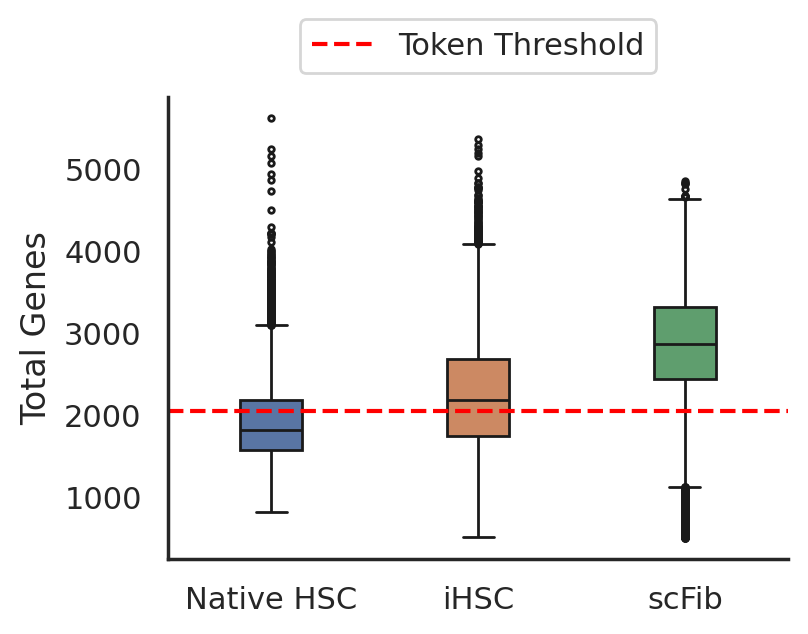

In [6]:
# Set Seaborn style and figure parameters
sns.set_style("white")
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

# Create the boxplot with customized outlier properties
sns.boxplot(
    data=df,
    x='label',
    y='total_length',
    hue='label',
    width=0.3,
    linecolor='k',
    flierprops={'markersize': 2},  
    linewidth=1, 
)

plt.axhline(
    y=2048, 
    color='red', 
    linestyle='dashed', 
    linewidth=1.5, 
    label=f'Token Threshold',
)

plt.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.2)
)

# Set labels and remove spines
plt.xlabel("")
plt.ylabel("Total Genes")
sns.despine()

In [7]:
# Create a new column to store the counts
df['token_count'] = 0

# Convert tokens to a set for efficient intersection
token_set = set(hsc_tokens['token_id'].to_list())

# Iterate over each row and count the number of matching tokens
for index, row in df.iterrows():
    list_set = set(row['input_ids'])
    intersection = token_set.intersection(list_set)
    df.at[index, 'token_count'] = len(intersection)

# Display the first 5 rows with the new column
df.head()

,n_genes,dataset_x,n_genes_by_counts,total_counts,obs_index,cell_type,dataset_y,standard_cell_type,cell_id,input_ids,length,total_length,label,token_count
0,1950,weng_young2_HSC,1949,11532.148941,AAACAGCCAACCCTAA-3,HSC,weng_young2_HSC,HSC,AAACAGCCAACCCTAA-3_weng_young2_HSC,"[3671, 1756, 14476, 7289, 24562, 14132, 1298, ...",2048,1949,Native HSC,30
1,1451,weng_young2_HSC,1446,8973.424214,AAACAGCCATAGGCGA-3,HSC,weng_young2_HSC,HSC,AAACAGCCATAGGCGA-3_weng_young2_HSC,"[14476, 7947, 7289, 2072, 8325, 2080, 4655, 23...",2048,1446,Native HSC,25
2,3804,weng_young2_HSC,3795,19644.194682,AAACATGCAGCTAACC-3,MKP,weng_young2_HSC,MKP,AAACATGCAGCTAACC-3_weng_young2_HSC,"[5150, 5926, 6354, 9151, 216, 3397, 9698, 1664...",2048,3795,Native HSC,28
3,2757,weng_young2_HSC,2755,15157.484346,AAACATGCAGGCTGTT-3,HSC,weng_young2_HSC,HSC,AAACATGCAGGCTGTT-3_weng_young2_HSC,"[2010, 24308, 1664, 6395, 5602, 8584, 4318, 34...",2048,2755,Native HSC,18
4,1933,weng_young2_HSC,1933,11302.743510,AAACCGCGTAAATTGC-3,MPP,weng_young2_HSC,MPP,AAACCGCGTAAATTGC-3_weng_young2_HSC,"[4503, 10047, 216, 6395, 7844, 7289, 1351, 426...",2048,1933,Native HSC,29


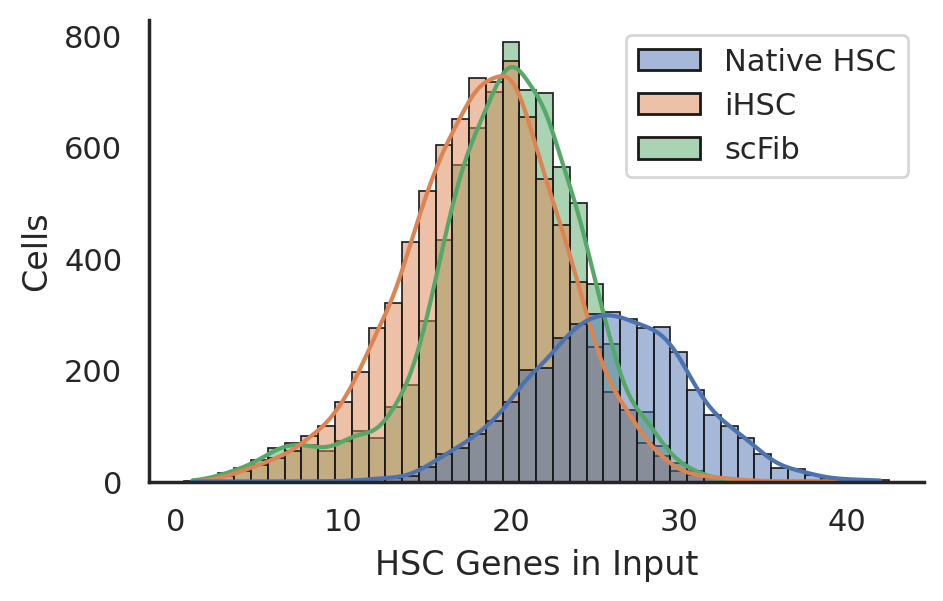

In [8]:
sns.set_style("white")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 3

sns.histplot(
    data=df,
    x='token_count',
    discrete=True,
    hue='label',
    ec='k',
    kde=True,
    # palette=["#00BFFF", "#FF4500"],
)

sns.move_legend(
    plt.gca(),
    title='',
    loc='best',
)

plt.ylabel('Cells')
plt.xlabel('HSC Genes in Input')

sns.despine()

In [9]:
# break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [10]:
fb_genes = list(pang[pang['Fibroblasts']].index)
print(fb_genes[:10])

fb_tokens = tokens[tokens['gene_name'].isin(fb_genes)]
print(f"{fb_tokens.shape=}")

['RARRES2', 'CELA1', 'LUM', 'PRRX1', 'SCARA5', 'COL1A1', 'COL5A2', 'COL5A1', 'FNDC1', 'COL12A1']
fb_tokens.shape=(231, 7)


In [11]:
# Create a new column to store the counts
df['token_count'] = 0

# Convert tokens to a set for efficient intersection
token_set = set(fb_tokens['token_id'].to_list())

# Iterate over each row and count the number of matching tokens
for index, row in df.iterrows():
    list_set = set(row['input_ids'])
    intersection = token_set.intersection(list_set)
    df.at[index, 'token_count'] = len(intersection)

# Display the first 5 rows with the new column
df.head()

,n_genes,dataset_x,n_genes_by_counts,total_counts,obs_index,cell_type,dataset_y,standard_cell_type,cell_id,input_ids,length,total_length,label,token_count
0,1950,weng_young2_HSC,1949,11532.148941,AAACAGCCAACCCTAA-3,HSC,weng_young2_HSC,HSC,AAACAGCCAACCCTAA-3_weng_young2_HSC,"[3671, 1756, 14476, 7289, 24562, 14132, 1298, ...",2048,1949,Native HSC,17
1,1451,weng_young2_HSC,1446,8973.424214,AAACAGCCATAGGCGA-3,HSC,weng_young2_HSC,HSC,AAACAGCCATAGGCGA-3_weng_young2_HSC,"[14476, 7947, 7289, 2072, 8325, 2080, 4655, 23...",2048,1446,Native HSC,13
2,3804,weng_young2_HSC,3795,19644.194682,AAACATGCAGCTAACC-3,MKP,weng_young2_HSC,MKP,AAACATGCAGCTAACC-3_weng_young2_HSC,"[5150, 5926, 6354, 9151, 216, 3397, 9698, 1664...",2048,3795,Native HSC,12
3,2757,weng_young2_HSC,2755,15157.484346,AAACATGCAGGCTGTT-3,HSC,weng_young2_HSC,HSC,AAACATGCAGGCTGTT-3_weng_young2_HSC,"[2010, 24308, 1664, 6395, 5602, 8584, 4318, 34...",2048,2755,Native HSC,12
4,1933,weng_young2_HSC,1933,11302.743510,AAACCGCGTAAATTGC-3,MPP,weng_young2_HSC,MPP,AAACCGCGTAAATTGC-3_weng_young2_HSC,"[4503, 10047, 216, 6395, 7844, 7289, 1351, 426...",2048,1933,Native HSC,19


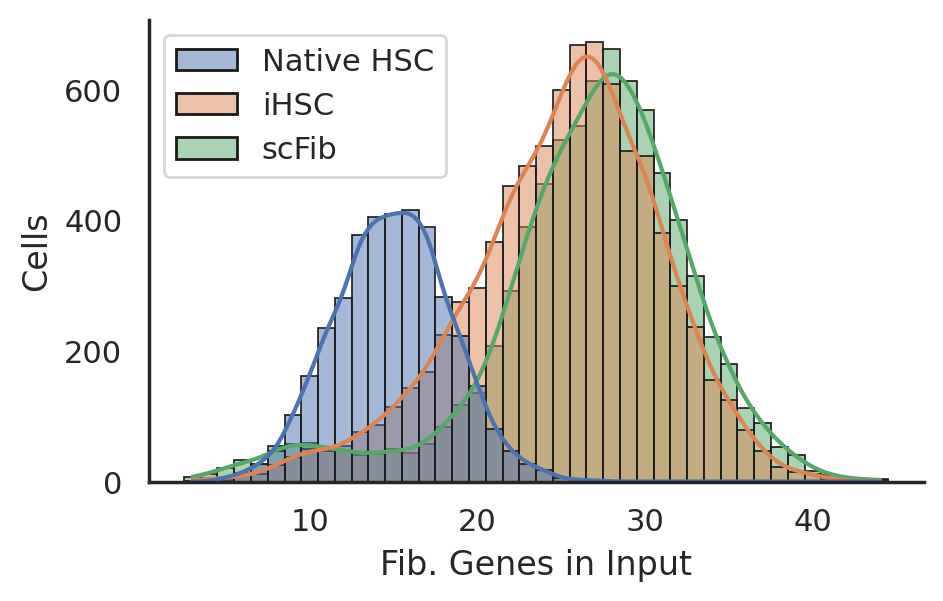

In [12]:
sns.set_style("white")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 3

sns.histplot(
    data=df,
    x='token_count',
    discrete=True,
    hue='label',
    ec='k',
    kde=True,
    # palette=["#00BFFF", "#FF4500"],
)

sns.move_legend(
    plt.gca(),
    title='',
    loc='best',
)

plt.ylabel('Cells')
plt.xlabel('Fib. Genes in Input')

sns.despine()